In [2]:
!pip install getFamaFrenchFactors --quiet

In [5]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gft

## Download Apple data

In [6]:
ticker = 'AAPL'
start = '2000-01-01'
end = '2024-08-31'
stock_data = yf.download(ticker, start, end)

# since FFF are monlty, use M and last price of the month
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = 'Month_Rtn'
stock_returns.index = pd.to_datetime(stock_returns.index).date
stock_returns

[*********************100%***********************]  1 of 1 completed
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_66866/845958417.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()


2000-02-29    0.104821
2000-03-31    0.184841
2000-04-30   -0.086517
2000-05-31   -0.322922
2000-06-30    0.247024
                ...   
2024-04-30   -0.006706
2024-05-31    0.130222
2024-06-30    0.095553
2024-07-31    0.054411
2024-08-31    0.032353
Name: Month_Rtn, Length: 295, dtype: float64

## Fama-French-3 Factor

In [7]:
ff3_monthly=gft.famaFrench3Factor(frequency='m')
ff3_monthly

,date_ff_factors,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...,...
1172,2024-03-31,0.0283,-0.0251,0.0421,0.0043
1173,2024-04-30,-0.0467,-0.0239,-0.0052,0.0047
1174,2024-05-31,0.0434,0.0078,-0.0166,0.0044
1175,2024-06-30,0.0277,-0.0306,-0.0331,0.0041


In [8]:
ff3_monthly.rename(columns={'date_ff_factors':'Date'}, inplace=True)
ff3_monthly.set_index('Date',inplace=True)
ff3_monthly.index = pd.to_datetime(ff3_monthly.index).date

In [11]:
# concat 'Return' and FF3
ff_data = pd.concat([ff3_monthly, stock_returns], axis=1, join='inner')
ff_data

,Mkt-RF,SMB,HML,RF,Month_Rtn
2000-02-29,0.0245,0.2136,-0.0959,0.0043,0.104821
2000-03-31,0.0520,-0.1720,0.0813,0.0047,0.184841
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.086517
2000-05-31,-0.0442,-0.0605,0.0475,0.0050,-0.322922
2000-06-30,0.0464,0.1284,-0.0842,0.0040,0.247024
...,...,...,...,...,...
2024-03-31,0.0283,-0.0251,0.0421,0.0043,-0.051286
2024-04-30,-0.0467,-0.0239,-0.0052,0.0047,-0.006706
2024-05-31,0.0434,0.0078,-0.0166,0.0044,0.130222
2024-06-30,0.0277,-0.0306,-0.0331,0.0041,0.095553


In [12]:
ff_data.columns = ['Beta','Size','Value','RF', 'Ret']
ff_data

,Beta,Size,Value,RF,Ret
2000-02-29,0.0245,0.2136,-0.0959,0.0043,0.104821
2000-03-31,0.0520,-0.1720,0.0813,0.0047,0.184841
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.086517
2000-05-31,-0.0442,-0.0605,0.0475,0.0050,-0.322922
2000-06-30,0.0464,0.1284,-0.0842,0.0040,0.247024
...,...,...,...,...,...
2024-03-31,0.0283,-0.0251,0.0421,0.0043,-0.051286
2024-04-30,-0.0467,-0.0239,-0.0052,0.0047,-0.006706
2024-05-31,0.0434,0.0078,-0.0166,0.0044,0.130222
2024-06-30,0.0277,-0.0306,-0.0331,0.0041,0.095553


## Regression model with FF3

In [13]:
X = ff_data[['Beta','Size', 'Value']]
y = ff_data['Ret'] - ff_data['RF'] # risk-premium

ff_model = sm.OLS(y,X).fit()
print(ff_model.summary())

b1,b2,b3 = ff_model.params

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.375
Model:                            OLS   Adj. R-squared (uncentered):              0.369
Method:                 Least Squares   F-statistic:                              58.27
Date:                Tue, 03 Sep 2024   Prob (F-statistic):                    1.57e-29
Time:                        14:51:20   Log-Likelihood:                          290.31
No. Observations:                 294   AIC:                                     -574.6
Df Residuals:                     291   BIC:                                     -563.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [14]:
ff_model.params

Beta     1.358210
Size     0.137417
Value   -0.736236
dtype: float64

# Insight :

1. Beta (Market Factor)
    - Coefficient (coef): 1.3582
    - P-value: 0.000
    - Interpretation: The beta value is 1.3582, which indicates that the portfolio is approximately 35.82% more volatile than the market. Since beta is greater than 1, it suggests that the portfolio is likely to experience higher gains when the market is up and larger losses when the market is down. The P-value of 0.000 indicates that this result is statistically significant.

2. Size (SMB, Small Minus Big Factor)
    - Coefficient (coef): 0.1374
    - P-value: 0.427
    - Interpretation: The size factor has a coefficient of 0.1374, which is positive, but the P-value is 0.427. This indicates that the result is not statistically significant, suggesting that the portfolio is not particularly exposed to small-cap or large-cap stocks. In other words, small or large stocks do not significantly influence the portfolio's performance.

3. Value (HML, High Minus Low Factor)
    - Coefficient (coef): -0.7362
    - P-value: 0.000
    - Interpretation: The value factor has a coefficient of -0.7362, which is negative, and the P-value is 0.000, making this result statistically significant. This suggests that the portfolio is more exposed to growth stocks rather than value stocks. Growth stocks have a more substantial influence on the portfolio’s performance compared to value stocks.

4. Residual Analysis and Other Statistics
    - Durbin-Watson: 1.877, indicating little to no autocorrelation in the residuals.
    - Skew: -0.101, which is close to zero, suggesting that the residuals are symmetrically distributed.
    - Kurtosis: 6.853, indicating that the residuals have a relatively high peak.
    - Jarque-Bera (JB) and Prob(JB): The JB statistic is quite high, and the P-value is 0.000, suggesting that the residuals may not follow a normal distribution.

### Overall Portfolio Analysis
- This portfolio is quite sensitive to market risk (beta) and is heavily exposed to growth stocks, implying that it can perform well when growth stocks are doing well. However, it may underperform when the market is down or when value stocks outperform growth stocks.

- Based on this analysis, a fund manager might consider reassessing the portfolio’s growth stock exposure or adjusting the risk level in response to market volatility. Additionally, given the lack of normality in the residuals, it may be worthwhile to consider alternative modeling approaches or adding more variables to improve the analysis.

#### Expected return

In [19]:
rf = ff_data['RF'].mean()
market_premium = ff_data['Beta'].mean()
size_premium = ff_data['Size'].mean()
value_premium = ff_data['Value'].mean()

# Expected monthly return 
expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium
# annual
expected_yearly_return = expected_monthly_return * 12
print('Expected Yearly Return: ' + str(expected_yearly_return))

Expected Yearly Return: 0.09872851632092008


## Time-Varying Beta(RollingOLS)

In [20]:
from statsmodels.regression.rolling import RollingOLS

In [22]:
# 3 years rolling (prams)
betas = RollingOLS.from_formula('Ret ~ Beta + Size + Value', data=ff_data, window=36).fit().params

In [23]:
betas

,Intercept,Beta,Size,Value
2000-02-29,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN,NaN
2000-06-30,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-03-31,0.007312,1.127279,-0.069533,-0.379661
2024-04-30,0.008170,1.104206,-0.075450,-0.387606
2024-05-31,0.011061,1.129658,-0.040972,-0.367304
2024-06-30,0.010731,1.141598,-0.102583,-0.355119


<Axes: >

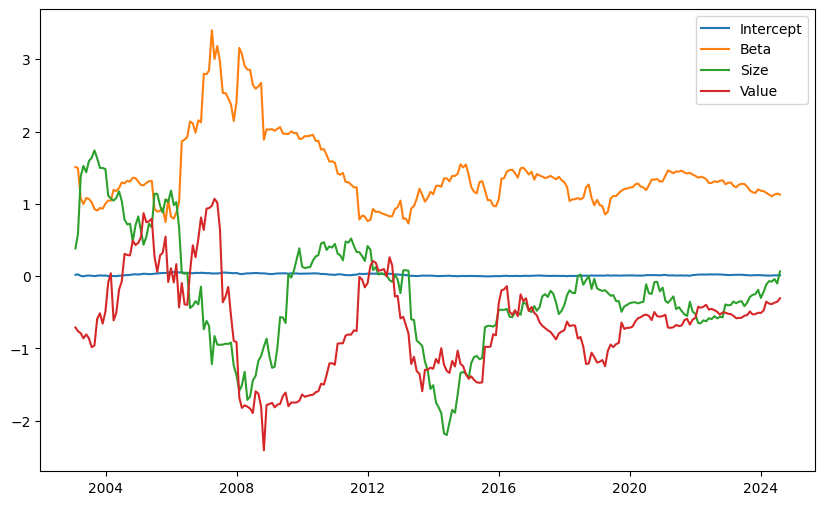

In [24]:
betas.dropna().plot(figsize=(10, 6))

파마-프렌치 3팩터 모델을 통해 얻은 정보를 펀드매니저들이 사용하는 방법은 다양합니다. 이 분석은 단순한 결과 도출에서 끝나는 것이 아니라, 실제 투자 전략을 수립하고 실행하는 데 중요한 역할을 합니다. 펀드매니저들이 이 정보를 사용하는 방법을 설명하면 다음과 같습니다:

1. 포트폴리오 구성
리스크 조정: 베타 값이 높은 주식(예: 애플)을 포트폴리오에 포함할 경우, 전체 포트폴리오의 변동성을 증가시킬 수 있습니다. 따라서 펀드매니저는 다른 변동성이 낮은 자산을 포함하여 포트폴리오의 리스크를 조정할 수 있습니다.
분산 투자: SMB와 HML 값이 음수인 대형 성장주(예: 애플)를 포함하면서도, 반대로 SMB와 HML 값이 양수인 소형 가치주를 함께 포함하여 다양한 시장 조건에 대비할 수 있는 포트폴리오를 구성할 수 있습니다.

2. 시장 예측과 리밸런싱
시장 전망: 시장이 상승할 것으로 예상된다면, 베타가 높은 주식(예: 애플)을 더 많이 포함시켜 수익을 극대화하려고 할 수 있습니다. 반대로 시장이 하락할 것으로 예상되면, 베타가 낮은 주식이나 방어적인 자산을 더 많이 포함시킬 수 있습니다.
리밸런싱: 시간이 지남에 따라 애플의 SMB, HML 값이 변화할 수 있기 때문에, 펀드매니저는 정기적으로 포트폴리오를 리밸런싱하여 전략적 노출을 조정합니다.

3. 스타일 로테이션 전략
성장주 vs. 가치주: HML 팩터를 통해 애플이 성장주로 분류되는 경우, 특정 경제 상황에서 성장주가 더 유리하게 평가될 수 있습니다. 예를 들어, 저금리 환경에서는 성장주가 더 좋은 성과를 낼 가능성이 있습니다. 펀드매니저는 이러한 환경 변화를 예측하고 포트폴리오의 성격을 조정할 수 있습니다.
대형주 vs. 소형주: SMB 팩터를 통해 대형주로 평가되는 애플의 포지션을 유지하거나, 시장이 소형주에 더 유리할 것으로 예상되면 소형주 비중을 늘릴 수 있습니다.

4. 리스크 관리
다운사이드 리스크 관리: 베타가 높다는 것은 시장 하락 시 애플의 주가도 큰 폭으로 하락할 수 있음을 의미합니다. 펀드매니저는 이를 감안하여 리스크 관리 전략(예: 헤징 전략)을 사용해 포트폴리오의 변동성을 줄일 수 있습니다.
팩터 리스크 관리: SMB나 HML 값이 특정 방향으로 편향되어 있다면, 펀드매니저는 해당 팩터가 포트폴리오에 미치는 영향을 줄이기 위한 전략을 도입할 수 있습니다.

5. 투자 성과 평가
벤치마크와의 비교: 펀드매니저는 파마-프렌치 모델의 팩터들을 기반으로 포트폴리오의 성과를 벤치마크와 비교할 수 있습니다. 예를 들어, 대형 성장주에 대한 노출이 얼마나 수익률에 기여했는지 분석할 수 있습니다.

6. 알파 생성
알파(Alpha): 베타 외에 SMB와 HML 팩터에 대한 이해는 펀드매니저가 시장을 초과하는 수익을 창출할 수 있는 기회를 발견하는 데 도움이 됩니다. 예를 들어, 시장이 특정 팩터를 잘 반영하지 못한다고 판단되면 그에 대한 포지션을 취해 알파를 창출할 수 있습니다.


요약
파마-프렌치 3팩터 모델은 펀드매니저들에게 단순히 주식의 성과를 평가하는 도구가 아니라, 보다 복잡하고 전략적인 포트폴리오 관리와 리스크 관리에 활용됩니다. 이 모델을 통해 펀드매니저는 보다 정교한 투자 결정을 내릴 수 있으며, 다양한 시장 상황에 맞추어 포트폴리오를 최적화할 수 있습니다.